<a href="https://colab.research.google.com/github/VanBap/Adverse_Weather/blob/master/Test_model_usingEfficientNetB0_tflite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Run this cell if u can't mount ur drive automatically
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Ngô Hoàng Khánh Văn - 20021599
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import glob
import pathlib
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image

#!pip install tensorflow-hub
#!pip install tf-nightly
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

MODEL_NAME_PATH = '/content/drive/MyDrive/KHOA_LUAN/saved_model/EfficientNetB0/EfficientNetB0_checkpoint_optimizing.tflite'

In [ ]:
train_data_dir = '/content/drive/MyDrive/KHOA_LUAN/DATASET/DATASET_splitted/train'
valid_data_dir = '/content/drive/MyDrive/KHOA_LUAN/DATASET/DATASET_splitted/val'
test_data_dir = '/content/drive/MyDrive/KHOA_LUAN/DATASET/DATASET_splitted/test'

img_height, img_width = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(preprocessing_function=None,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True
                                   )
# tạo dữ liệu tăng cường: xoay ảnh = 0.2; phóng to = 0.2; lật ảnh ngang; giữ 40% cho validation

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical')
    #subset='training') # set as training data

valid_generator = train_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical')
    #subset='validation') # set as validation data

test_generator = train_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size = 1,
    class_mode='categorical')
    #subset='validation') # set as testing data

train_generator.class_indices
valid_generator.class_indices
test_generator.class_indices

Found 1289 images belonging to 7 classes.
Found 428 images belonging to 7 classes.
Found 435 images belonging to 7 classes.


{'Cloudy': 0,
 'Fog': 1,
 'Rainy': 2,
 'Sandy': 3,
 'Shine': 4,
 'Snowy': 5,
 'Sunrise': 6}

**Test độ chính xác của model .tflite sau khi được lượng tử hóa float16**




In [ ]:
import tensorflow as tf
import time
import numpy as np
# Load model
model_path = MODEL_NAME_PATH
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
# Resize Tensor Shape
interpreter.resize_tensor_input(input_details[0]['index'], (1, 224, 224, 3))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
# Perform evaluation
print("input_details is: ", input_details)
print("input_details is: ", output_details)
correct_predictions = 0
total_samples = 0
inference_time = 0
average_inference_time = 0
sum_inference_time = 0
for images, labels in test_generator:
    interpreter.set_tensor(input_details[0]['index'], images)

    # Measure inference time and resource usage
    start_time = time.time()
    # Perform inference
    interpreter.invoke()
    end_time = time.time()
    inference_time = end_time - start_time

    sum_inference_time += inference_time

    output_data = interpreter.get_tensor(output_details[0]['index'])
    #predictions = tf.argmax(output_data, axis=1)
    predictions = np.argmax(output_data)

    temp_labels = np.argmax(labels) # convert one-hot encoding to oct
    correct_predictions += tf.cast(tf.equal(predictions, temp_labels), dtype=tf.float32)
    if tf.equal(predictions, temp_labels) == False:
      print("=================================")
      print("! WRONG ANSWER !")
      print('predictions is: ', predictions)
      print('label is: ', labels)
      print('correct_predictions is', correct_predictions)

    else:
      print("=================================")
      print("RIGHT ANSWER")
      print('correct_predictions is', correct_predictions)
    total_samples += len(labels)

    # Thêm điều kiện để thoát khỏi vòng lặp khi đã thử nghiệm hết tất cả các mẫu
    if total_samples >= len(test_generator.filenames):
        break

average_inference_time = sum_inference_time / total_samples

input_details is:  [{'name': 'serving_default_efficientnetb0_input:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
input_details is:  [{'name': 'StatefulPartitionedCall:0', 'index': 661, 'shape': array([1, 7], dtype=int32), 'shape_signature': array([-1,  7], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
RIGHT ANSWER
correct_predictions is tf.Tensor(1.0, shape=(), dtype=float32)
RIGHT ANSWER
correct_predictions is tf.Tensor(2.0, shape=(), dtype=float32)
RIGHT ANSWER
correct_predictions is tf.Tensor(3.0, shape=()

In [ ]:
# Calculate accuracy
test_accuracy = correct_predictions / total_samples
print('Total samples:', total_samples)
print('Correct predictions:', correct_predictions)
print('Test accuracy:', test_accuracy.numpy())
print('Interfernce time:', inference_time)
print('Average interfernce time:', average_inference_time)



Total samples: 435
Correct predictions: tf.Tensor(376.0, shape=(), dtype=float32)
Test accuracy: 0.86436784
Interfernce time: 0.06071591377258301
Average interfernce time: 0.07370257542051117


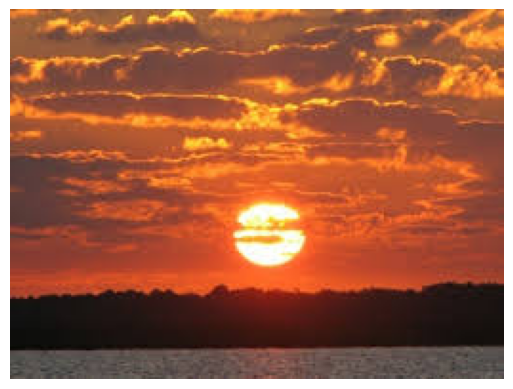

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.applications.resnet import preprocess_input

# Đường dẫn tới ảnh cần dự đoán
image_url = "/content/drive/MyDrive/KHOA_LUAN/DATASET/DATASET_splitted/test/Sunrise/sunrise11.jpg"

# Display the image
plt.imshow(Image.open(image_url))
plt.axis('off')
plt.show()
